In [51]:
import re
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from joblib import dump
from sklearn.metrics import (plot_confusion_matrix,
                             classification_report)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# pipeline
from sklearn.pipeline import Pipeline

# for the preprocessors
from sklearn.base import BaseEstimator, TransformerMixin

# for imputation
from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    MeanMedianImputer)

# for encoding categorical variables
from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder)


In [75]:
wandb.login()
run = wandb.init(project="Titanic-Classification", entity="nclgbd", reinit=True)
api = wandb.Api()

In [53]:
# list of variables to be used in the pipeline's transformers
NUMERICAL_VARIABLES = ['age', 'fare']
CATEGORICAL_VARIABLES = ['sex', 'cabin', 'embarked']
CABIN = ['cabin']

DATA_DIR = "data/train.csv"
TEST_DIR = "data/test.csv"

In [54]:
# load the data - it is available open source and online
data = pd.read_csv(DATA_DIR)
new_columns_dict = dict(zip(data.columns, [col.lower() for col in data.columns]))
data = data.rename(columns=new_columns_dict)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [63]:
# drop unnecessary variables
data = data.drop(labels=['name', 'ticket'], axis=1)
data["fare"] = data[NUMERICAL_VARIABLES]['fare']
data["age"] = data[NUMERICAL_VARIABLES]['age']
data["sex"] = data[CATEGORICAL_VARIABLES]["sex"]
data["embarked"] = data[CATEGORICAL_VARIABLES]["embarked"]
data.head()

,passengerid,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


In [56]:
data = data.replace('?', np.nan)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [77]:
def _train(model_name:str, X, y):
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    
    skf = StratifiedKFold(n_splits=5)
    X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(X, y)
    
    for train_idx, valid_idx in skf.split(X_resampled, y_resampled):
        # split the data
        X_train, X_valid = X_resampled.iloc[train_idx], X_resampled.iloc[valid_idx]
        y_train, y_valid = y_resampled.iloc[train_idx], y_resampled.iloc[valid_idx]
        
        avail_models = {"Logit": LogisticRegression(C=0.0005, random_state=0),
                        "SVC": SVC(random_state=42, probability=True)}

        model =  avail_models[model_name]
        
        # set up the pipeline
        titanic_pipe = Pipeline([
            # ===== IMPUTATION =====
            # impute categorical variables with string missing
            ('categorical_imputation', CategoricalImputer(
                imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

            # add missing indicator to numerical variables
            ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES)),

            # impute numerical variables with the median
            ('median_imputation', MeanMedianImputer(
                imputation_method='median', variables=NUMERICAL_VARIABLES)),

            # == CATEGORICAL ENCODING ======
            # remove categories present in less than 5% of the observations (0.05)
            # group them in one category called 'Rare'
            ('rare_label_encoder', RareLabelEncoder(
                tol=0.05, n_categories=1, variables=CATEGORICAL_VARIABLES)),

            # encode categorical variables using one hot encoding into k-1 variables
            ('categorical_encoder', OneHotEncoder(
                drop_last=True, variables=CATEGORICAL_VARIABLES)),

            # scale
            ('scaler', StandardScaler()),

            # predict
            (model_name, model),
        ])
        
        titanic_pipe.fit(X_train, y_train)
        return titanic_pipe, X_train, X_valid, y_train, y_valid
        

In [72]:
def train(model_name:str, X, y, dry_run=True):
    fname = "".join(["models/", model_name.lower(), "-model", '.joblib'])
    titanic_pipe, X_train, X_valid, y_train, y_valid, = _train(model_name, X, y)
    y_probas = titanic_pipe.predict_proba(X_valid)
    y_pred = titanic_pipe.predict(X_valid)
    
    if dry_run:
        print(classification_report(y_valid, y_pred))
        plot_confusion_matrix(titanic_pipe, X_valid, y_valid)
           
    else:
        with run:
            wandb.log({"metrics": wandb.sklearn.plot_summary_metrics(titanic_pipe, 
                                                                     X_train, y_train, 
                                                                     X_valid, y_valid)})
            
            wandb.log({"roc": wandb.sklearn.plot_roc(y_valid, y_probas, 
                                                     labels=titanic_pipe.classes_)})
            
            wandb.log({"pr": wandb.plot.pr_curve(y_valid, y_probas)})
            
            wandb.log({"cm": wandb.sklearn.plot_confusion_matrix(y_valid, y_pred, labels=titanic_pipe.classes_)})
            
            #artifact = wandb.Artifact(fname, type='model')
            #artifact.add_file(fname)
    
    dump(titanic_pipe, fname)
          

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       110
           1       0.83      0.75      0.78       110

    accuracy                           0.80       220
   macro avg       0.80      0.80      0.79       220
weighted avg       0.80      0.80      0.79       220



C:\Users\nicol\Anaconda3\envs\tcss551_titanic\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


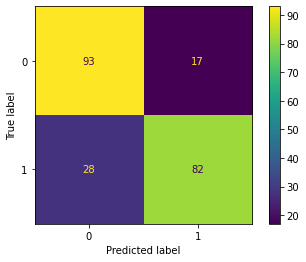

In [79]:
train("SVC", 
      data.drop('survived', axis=1),
      data['survived'])#, dry_run=False)